# band-pass filtering: movies

Multiply by an harmonic signal and low-pass filter

useful [link](https://www.dsprelated.com/showarticle/938.php)

with `apply_ufunc`, an alternative would have been with [xscale](http://xscale.readthedocs.io/en/latest/)


---

In [1]:
import os, sys, shutil
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from scipy import signal
import scipy.ndimage as im

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.start_workers(20) # 40

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.13:59495 Dashboard: http://10.148.1.13:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

# 0: variable select and path


In [5]:
v = 'SSU'

# dir where filtered data is stored
out_dir = scratch+'/mit_filtered/'
#out_dir = osi+'/mit_filtered/'

--- 

# 1: One face 

## load data

In [6]:
face = 1

In [41]:
grid = xr.open_zarr(scratch+'/mit_grid.zarr')
grid = grid.isel(face=face).drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])
print(grid)

<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320)
Coordinates:
    Depth    (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(96, 96)>
    XC       (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(96, 96)>
    YC       (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(96, 96)>
    face     int64 1
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    rA       (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(96, 96)>
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data


In [46]:
ds = xr.open_zarr(out_dir+'/%s_filtered_f%02d.zarr'%(v, face))
ds = xr.merge([ds,grid])

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:    (i: 4320, j: 4320, time: 8640)
Coordinates:
    dtime      (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(8640,)>
    face       int64 1
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time       (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
    time_days  (time) float64 dask.array<shape=(8640,), chunksize=(8640,)>
    Depth      (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(96, 96)>
    XC         (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(96, 96)>
    YC         (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(96, 96)>
    rA         (j, i) float32 dask.array<shape=(4320, 4320), chunksize=(96, 96)>
Data variables:
    SSU        (j, i, time) complex64 dask.array<shape=(4320, 4320, 8640), chunksize=(96, 96, 8640)>

 data size: 1290.2 GB


In [14]:
# apply_ufunc requires one chunk along core dimensions
#chunks={'time': len(ds['time']), 'i':96,'j': 96}
#chunks={'time': len(ds['time']), 'i':32,'j': 96} # if no prior rechunking
#chunks={'time': len(ds['time'])}
#%time ds = ds.chunk(chunks)

In [15]:
#%time ds = ds.persist()

---

## movie of one face

not working yet

In [47]:
# tmp
#ds = ds.isel(time=slice(100,300))

#ds = ds.chunk({'time': 1, 'i': len(ds.i), 'j':len(ds.j)}) # blows memory
#maybe:
ds = ds.chunk({'time': 10, 'i': len(ds.i), 'j':len(ds.j)})
%time ds = ds.persist()
# this rechunking is hard
20 workers maybe not enough for this

CPU times: user 5.91 s, sys: 88 ms, total: 6 s
Wall time: 5.97 s


In [30]:
print(ds)

<xarray.Dataset>
Dimensions:    (i: 4320, j: 4320, time: 200)
Coordinates:
    dtime      (time) datetime64[ns] dask.array<shape=(200,), chunksize=(10,)>
    face       int64 ...
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time       (time) float64 6.062e+06 6.066e+06 6.07e+06 6.073e+06 ...
    time_days  (time) float64 dask.array<shape=(200,), chunksize=(10,)>
Data variables:
    SSU        (j, i, time) complex64 dask.array<shape=(4320, 4320, 200), chunksize=(4320, 4320, 10)>


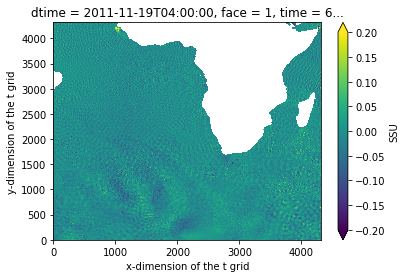

In [39]:
np.real(ds[v]).isel(time=0).plot(vmin=-.2,vmax=.2)

In [44]:
#face = 1
vmin = -.2
vmax = .2

#
figdir = scratch+'/figs/'
shutil.rmtree(figdir); os.mkdir(figdir)

def process(lds, i, overwrite=True):
        
    #lv = lds[v].isel(face=face)
    lv = np.real(lds[v])

    time = pd.to_datetime(str(lv.dtime.values))
    
    figname = figdir+'mit_'+v+'_f%02d_t%05d.png'%(face, i)
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = '%s face=%02d : '%(v, face) 
        title += time.strftime('%Y/%m/%d %H:%M')
        plot_scalar(lv, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10), cmmap='balance')
        #
        m = np.abs(lv.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
I = range(100)
values = [dask.delayed(process)(ds.isel(time=i), i) for i in I]

In [45]:
%time results = dask.compute(*values, get=client.get)

CPU times: user 12.5 s, sys: 932 ms, total: 13.4 s
Wall time: 1min 8s


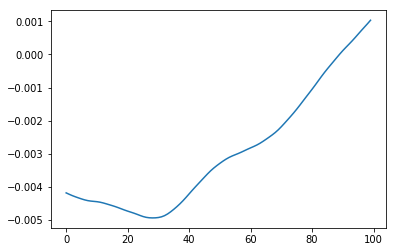

In [33]:
plt.plot(results)

---

In [27]:
# add workers
w = cluster.start_workers(10)

In [49]:
# kill scheduler, workers
cluster.scheduler.close()
#cluster.stop_workers(cluster.jobs)

<Future pending cb=[_make_coroutine_wrapper.<locals>.wrapper.<locals>.<lambda>() at /home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py:336]>

In [ ]:
# restart workers
client.restart()

In [48]:
client

Client Scheduler: tcp://10.148.1.13:59495 Dashboard: http://10.148.1.13:8787/status,Cluster Workers: 38 Cores: 152 Memory: 1900.00 GB
